          ID  Severity        Start_Time          End_Time  Start_Lat  \
0  A-2716600         3  08-02-2016 00:37  08-02-2016 06:37   40.10891   
1  A-2716601         2  08-02-2016 05:56  08-02-2016 11:56   39.86542   
2  A-2716602         2  08-02-2016 06:15  08-02-2016 12:15   39.10266   
3  A-2716603         2  08-02-2016 06:15  08-02-2016 12:15   39.10148   
4  A-2716604         2  08-02-2016 06:51  08-02-2016 12:51   41.06213   

   Start_Lng   End_Lat   End_Lng  Distance(mi)  \
0  -83.09286  40.11206 -83.03187         3.230   
1  -84.06280  39.86501 -84.04873         0.747   
2  -84.52468  39.10209 -84.52396         0.055   
3  -84.52341  39.09841 -84.52241         0.219   
4  -81.53784  41.06217 -81.53547         0.123   

                                         Description  ...  Roundabout Station  \
0  Between Sawmill Rd/Exit 20 and OH-315/Olentang...  ...       False   False   
1                 At OH-4/OH-235/Exit 41 - Accident.  ...       False   False   
2                

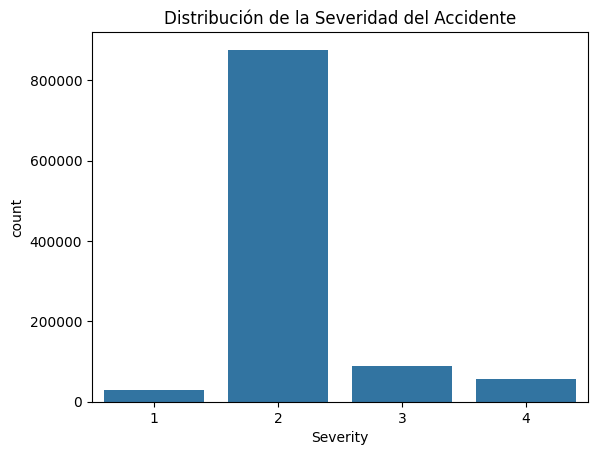

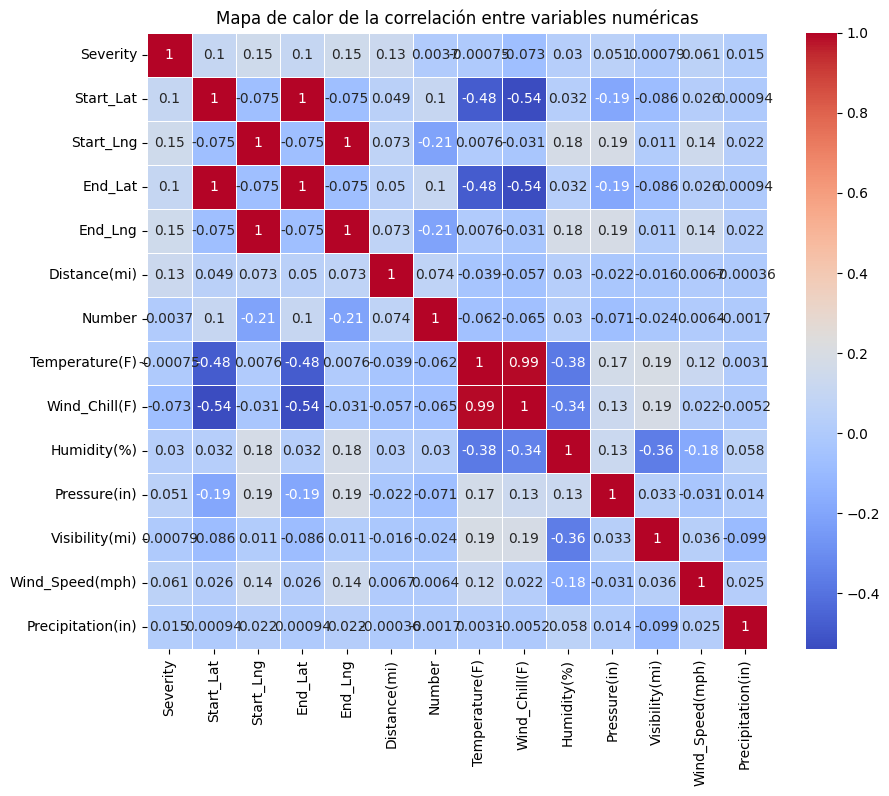

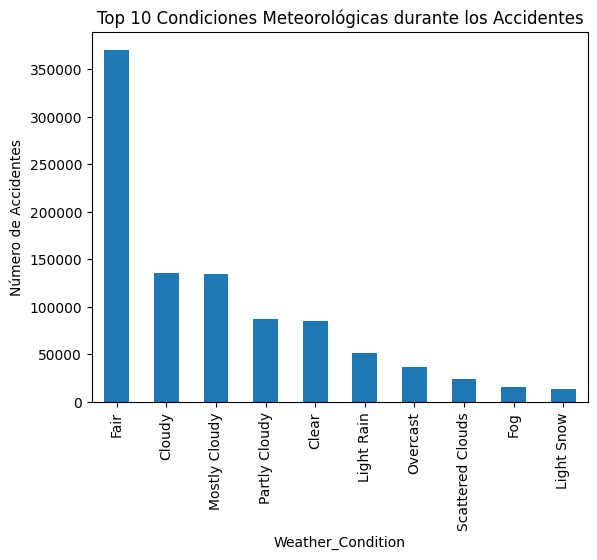

Nuevas características:
   Day_of_Week  Is_Weekend  Hour
0          0.0           0   0.0
1          0.0           0   5.0
2          0.0           0   6.0
3          0.0           0   6.0
4          0.0           0   6.0

Top 5 características más importantes:
     Feature  MI_Score
0   Severity  0.521818
4    End_Lng  0.219048
2  Start_Lng  0.218534
3    End_Lat  0.201596
1  Start_Lat  0.201012

Número de componentes principales: 12
Varianza explicada total: 0.96
Nuevas características creadas:
   Adverse_Weather_Condition  Temperature_Deviation  Climate_Risk_Index
0                          0             -17.057968           -0.000000
1                          0             -22.257968           -0.000000
2                          0             -23.157968          -23.157968
3                          0             -23.157968          -23.157968
4                          0             -20.157968          -20.157968

Informe de clasificación:
              precision    recall  f1-s

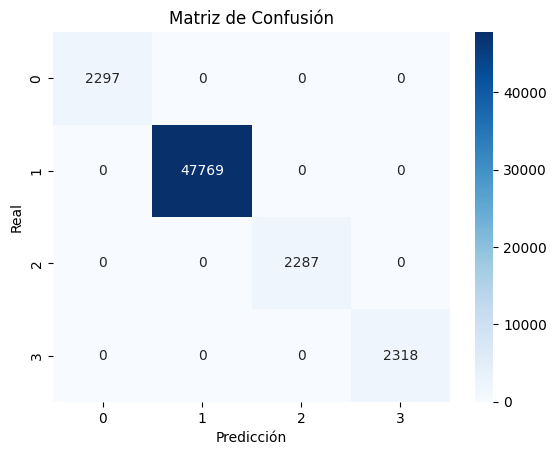

In [1]:
# -*- coding: utf-8 -*-
"""DMT_Trabajo_Parcial

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/13RU_SLnWQ3TwyNqM21wpH-mXkq_phjzl

Dataset: https://www.kaggle.com/datasets/sasikumarg/us-accidents/data
"""

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Cargar el dataset
df = pd.read_csv('US_Accidents.csv')

# Mostrar las primeras filas del dataset
print(df.head())

# Información general del dataset
print(df.info())

# Mostrar estadísticas descriptivas básicas
print(df.describe())

# Revisar valores nulos por columna
print(df.isnull().sum())

# Distribución de la variable 'Severity'
sns.countplot(x='Severity', data=df)
plt.title('Distribución de la Severidad del Accidente')
plt.show()

# Seleccionar solo las columnas numéricas
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Matriz de correlación solo con las columnas numéricas
corr_matrix = numeric_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de calor de la correlación entre variables numéricas')
plt.show()

# Ver cuántos accidentes ocurrieron bajo distintas condiciones meteorológicas
weather_counts = df['Weather_Condition'].value_counts().head(10)
weather_counts.plot(kind='bar')
plt.title('Top 10 Condiciones Meteorológicas durante los Accidentes')
plt.ylabel('Número de Accidentes')
plt.show()

# Convertir las fechas especificando el formato correcto
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='%d-%m-%Y %H:%M', errors='coerce')

# Crear nuevas características
df['Hour'] = df['Start_Time'].dt.hour
df['Day_of_Week'] = df['Start_Time'].dt.dayofweek
df['Is_Weekend'] = df['Start_Time'].dt.dayofweek.isin([5, 6]).astype(int)

print("Nuevas características:")
print(df[['Day_of_Week', 'Is_Weekend', 'Hour']].head())

# 2. Selección de características
df_clean = df.dropna()
numeric_features = df_clean.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calcular la dependencia mutua entre las características numéricas y 'Severity'
mi_scores = mutual_info_regression(df_clean[numeric_features], df_clean['Severity'])
mi_scores_df = pd.DataFrame({'Feature': numeric_features, 'MI_Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values('MI_Score', ascending=False)

# Mostrar las 5 características más importantes
print("\nTop 5 características más importantes:")
print(mi_scores_df.head())

# 3. Reducción de dimensionalidad
X_clean = df_clean[numeric_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# Aplicar PCA para capturar el 95% de la varianza
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Resultados de PCA
print(f"\nNúmero de componentes principales: {pca.n_components_}")
print(f"Varianza explicada total: {sum(pca.explained_variance_ratio_):.2f}")

# Crear un índice de riesgo climático y otras características adicionales
adverse_conditions = ['Rain', 'Snow', 'Fog', 'Sleet', 'Hail']
df['Adverse_Weather_Condition'] = df['Weather_Condition'].apply(lambda x: 1 if x in adverse_conditions else 0)
mean_temperature = df['Temperature(F)'].mean()
df['Temperature_Deviation'] = df['Temperature(F)'] - mean_temperature

weather_scores = {
    'Clear': 0,
    'Partly Cloudy': 0,
    'Overcast': 1,
    'Rain': 2,
    'Snow': 3,
    'Fog': 3,
    'Sleet': 3,
    'Hail': 4
}

df['Weather_Score'] = df['Weather_Condition'].map(weather_scores).fillna(0)
df['Climate_Risk_Index'] = df['Temperature_Deviation'] * df['Weather_Score']

print("Nuevas características creadas:")
print(df[['Adverse_Weather_Condition', 'Temperature_Deviation', 'Climate_Risk_Index']].head())

# 4. Preparar los datos para el modelo
X = df_clean[numeric_features]
y = df_clean['Severity']  # Variable objetivo

# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Entrenar un modelo de clasificación
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 6. Hacer predicciones
y_pred = model.predict(X_test)

# 7. Evaluar el modelo
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


In [2]:

# Nueva característica: Condiciones de la Carretera
if 'Weather_Condition' in df.columns:
    df['Road_Condition'] = df['Weather_Condition'].map({'Clear': 0, 'Rain': 1, 'Snow': 2, 'Ice': 3})
else:
    df['Road_Condition'] = 'Unknown'  # O maneja el caso si no existe

# Nueva característica: Edad del Conductor
if 'Driver_Birth_Year' in df.columns:
    df['Driver_Age'] = 2024 - df['Driver_Birth_Year']  # Supón que tienes el año actual como 2024
else:
    df['Driver_Age'] = None  # Maneja el caso si no existe

# Nueva característica: Distancia en kilómetros (si quieres convertir de millas a kilómetros)
df['Distance(km)'] = df['Distance(mi)'] * 1.60934


In [3]:

# Nueva característica: Estado del Clima
df['Weather_Temperature'] = df['Temperature(F)']  # O puedes mapear a diferentes estados

# Nueva característica: Velocidad del Viento (en m/s)
df['Wind_Speed(m/s)'] = df['Wind_Speed(mph)'] * 0.44704

# Nueva característica: Visibilidad en metros
df['Visibility(m)'] = df['Visibility(mi)'] * 1609.34


In [4]:

# Nueva característica: Humedad en porcentaje
df['Humidity(%)'] = df['Humidity(%)']

# Nueva característica: Presión (puedes convertir si es necesario)
df['Pressure(Pa)'] = df['Pressure(in)'] * 3386.39  # Conversión de pulgadas a pascales

# Nueva característica: Descripción simplificada
df['Simple_Description'] = df['Description'].apply(lambda x: x.split('.')[0])  # Solo la primera frase

# Imprimir las columnas disponibles
print("Columnas disponibles en el DataFrame:", df.columns.tolist())

# Verificar el DataFrame
try:
    print(df[['Road_Condition', 'Driver_Age', 'Distance(km)', 'Weather_Temperature', 
               'Wind_Speed(m/s)', 'Visibility(m)', 'Humidity(%)', 'Pressure(Pa)', 
               'Simple_Description']].head())
except KeyError as e:
    print(f"Error: {e}. Asegúrate de que todas las columnas existen.")


Columnas disponibles en el DataFrame: ['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Hour', 'Day_of_Week', 'Is_Weekend', 'Adverse_Weather_Condition', 'Temperature_Deviation', 'Weather_Score', 'Climate_Risk_Index', 'Road_Condition', 'Driver_Age', 'Distance(km)', 'Weather_Temperature', 'Wind_Speed(m/s)', 'Visibility(m)', 'Pressure(Pa)', 'Simple_Description']
   Road_Condition Driver_Age 